# Vindr-Mammo dataset analysis (BIRADS)

As described by the authors, the project directory contains the following files and subfolder:

- **Annotations files**:  
  - `breast-level_annotations.csv`  
  - `finding_annotations.csv`  
- **Metadata file**:  
  - `metadata.csv`  
- **Subfolder**:  
  - `images` (contains DICOM files)

---

### `images` Subfolder

- Contains **5,000 subdirectories**, each corresponding to an exam in the dataset.
- The **folder name** is the hashed study identifier of the exam.
- Each folder contains **four DICOM files** for two standard views of each breast.
- **Path format**:  
  `images/<study_id>/<image_id>.dicom`

---

### Annotations Files

#### `breast-level_annotations.csv`

- Each row corresponds to an image and provides the BI-RADS assessment along with metadata.
- **Attributes**:
  - `study_id`: Encoded study identifier.
  - `series_id`: Encoded series identifier.
  - `laterality`: Laterality of the breast (L or R).
  - `view_position`: Orientation of the image (CC or MLO).
  - `height`: Height of the image.
  - `width`: Width of the image.
  - `breast_birads`: BI-RADS assessment of the breast.
  - `breast_density`: Density category of the breast.
  - `split`: Indicates the split to which the image belongs (`training` or `test`).

---

#### `finding_annotations.csv`

- Each row represents an annotation of a breast abnormality in an image.
- **Image metadata**:  
  - `image_id`, `study_id`, `series_id`, `laterality`, `view_position`, `height`, `width`, `breast_birads`, `breast_density`, `split`
- **Annotation metadata**:
  - `finding_categories`: List of finding categories (e.g., `["Mass", "Skin Retraction"]`).
  - `finding_birads`: BI-RADS assessment of the marked finding.
  - `xmin`, `ymin`, `xmax`, `ymax`: Coordinates of the bounding box.

---

### `metadata.csv`

- Contains DICOM tag information relevant for research:
  - Patient's age.
  - Imaging device model.
  - Manufacturer.

In [15]:
from glob import glob 

data_dir = "/mnt/d/datasets/vindr-mammo/data"
f_list = glob(data_dir + '/*')
print('The dataset directory contains :')
for i in f_list:
    print(f'    - {i}')

The dataset directory contains :
    - /mnt/d/datasets/vindr-mammo/data/LICENSE.txt
    - /mnt/d/datasets/vindr-mammo/data/SHA256SUMS.txt
    - /mnt/d/datasets/vindr-mammo/data/breast-level_annotations.csv
    - /mnt/d/datasets/vindr-mammo/data/finding_annotations.csv
    - /mnt/d/datasets/vindr-mammo/data/metadata.csv
    - /mnt/d/datasets/vindr-mammo/data/npy
    - /mnt/d/datasets/vindr-mammo/data/images
    - /mnt/d/datasets/vindr-mammo/data/prepared
    - /mnt/d/datasets/vindr-mammo/data/light_augmentations


According to the dataset description : 

- finding_annotations.csv, could be used to prepare the dataset for both lesion-based classification and segmentation tasks.
- breast-level_annotations.csv, could be used to prepare the dataset for a bi-rads based classification.

### Extraction protocol - birads-based classification

1. Get the names of unique birads
2. Rename the breast_birads cells of the finding_annotations.csv to facilitate later access to this column. 
3. Remove any row where breast_birads is NaN.
4. Create a filter to reset the assessments according to the 3-category system (birads from 0 to 2).
5. Iterate through the rows and load the dicom file using study_id and image_id. (optional) Create and display a bounding box on the annotated lesion. 

##### 1. Names of unique finding categories

In [16]:
import ast
import os
import pandas as pd
import numpy as np

df_find = pd.read_csv(os.path.join(data_dir, 'finding_annotations.csv'))
original_df_find_len = len(df_find)

unique_birads = df_find['breast_birads'].unique()
print('Unique assessments found :')
for i in unique_birads:
    print(f'    - {i}')

Unique assessments found :
    - BI-RADS 4
    - BI-RADS 3
    - BI-RADS 5
    - BI-RADS 2
    - BI-RADS 1


##### 2. Rename birads assessments

In [17]:
def format_char(char):
    return char.lower().replace(' ', '_')

df_find['breast_birads'] = df_find['breast_birads'].apply(format_char)

print('Sample of newly named birad assessment : ', df_find['breast_birads'].iloc[5])

Sample of newly named birad assessment :  bi-rads_4


##### 3. Check if there are rows without birads

In [18]:
has_nan_birads = df_find['breast_birads'].isna().unique()

has_nan_birads

array([False])

All studies have defined finding categories, continuing ...

##### 4. Create the 3-category birads system

Just like stated by the authors : 

"For the screening purpose, the dataset can be directly used to evaluate CAD after converting the provided BI-RADS annotations in 5 categories to the 3-category system: BI-RAS 0 (recall, correspond to BI-RADS 3, BI-RADS 4, BI-RADS 5), BI-RAS 1 (normal, correspond to BI-RADS 1), BI-RAS 2 (benign, correspond to BI-RADS 2)"

In [19]:
label_counts = df_find['breast_birads'].value_counts()
print(label_counts)

mapping = {
    'bi-rads_1': 'bi-rads_1',
    'bi-rads_2': 'bi-rads_2', 
    'bi-rads_3': 'bi-rads_0',
    'bi-rads_4': 'bi-rads_0', 
    'bi-rads_5': 'bi-rads_0'
}

df_find['breast_birads'] = df_find['breast_birads'].replace(mapping)

print('New count')
label_counts = df_find['breast_birads'].value_counts()
print(label_counts)

breast_birads
bi-rads_1    13406
bi-rads_2     4676
bi-rads_4     1005
bi-rads_3      972
bi-rads_5      427
Name: count, dtype: int64
New count
breast_birads
bi-rads_1    13406
bi-rads_2     4676
bi-rads_0     2404
Name: count, dtype: int64


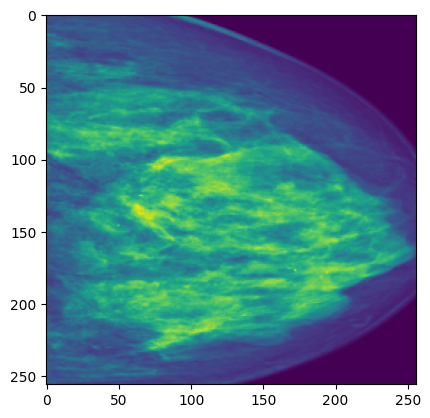

In [17]:
from glob import glob
import cv2, sys
sys.path.insert(0, "../")

import matplotlib.pyplot as plt
from src.utils.normalization import truncate_normalization
from src.utils.image import crop_to_roi

images = glob('/mnt/d/datasets/vindr-mammo/data/raw/train/no_finding/*.png')
sample, mask = crop_to_roi(cv2.imread(images[0], cv2.IMREAD_GRAYSCALE))
normalized = truncate_normalization(sample, mask)
plt.imshow(cv2.imread(images[0], cv2.IMREAD_GRAYSCALE))
plt.show()


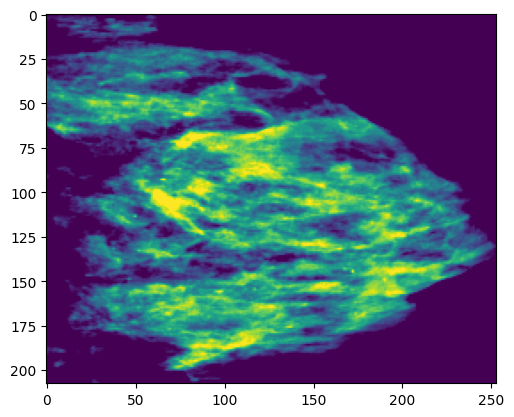

In [18]:
plt.imshow(normalized)
plt.show()